#### thankGOD! this code should be run in the tf_env of conda and can not be run in base enviroment of conda thankGOD!

In this code we want to use NN to predict the Rg of IDPs. The training data set is 28000 simulation proteins of Keresten group with 12 sequence features but the test set is 137 experimental data of Alex Holehouse. So here we evaluate our NN model which is trained on simulation data to predict experimental results.

### Step 1: Import Libraries

In [98]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.regularizers import l2



In [99]:
%cd /media/saeed/Expansion/ASU/md-intro-tutorial/ml_project/Alex/data/

/media/saeed/Expansion/ASU/md-intro-tutorial/ml_project/Alex/data


Define main data set

In [100]:
# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('IDRome_DB.csv', usecols=['Rg/nm','N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD',	'faro','kappa','fcr'])

# Separate the target (Rg) and features   
X_large = df.drop(columns=['Rg/nm'])  # Features (all columns except 'Rg')
y_large = df['Rg/nm']  # Target (only the 'Rg' column)

### Define 137 exp deta set of Alex for test

In [101]:
df = pd.read_excel('features.xlsx', usecols=[' SAXS Rg (nm)','N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD','faro','kappa','fcr'])

# Separate the target (Rg) and features
X_small = df.drop(columns=[' SAXS Rg (nm)'])  # Features (all columns except 'Rg')
y_small= df[' SAXS Rg (nm)']  # Target (only the 'Rg' column)

In [102]:
print(X_small.shape,'', X_large.shape)

(137, 12)  (28058, 12)


### Step 2: Preprocess the Data

Neural networks work better when the data is standardized (scaled to have a mean of 0 and standard deviation of 1).

In [103]:
#Clear the Session: If you’re running the script multiple times in the same session (e.g., in Jupyter), 
#clear TensorFlow's computational graph between runs to avoid accumulation:
from tensorflow.keras.backend import clear_session
clear_session()


In [104]:
import random
import tensorflow as tf

# Set random seed for reproducibility. Always will get same result. but if I do not use it, every time that I run I got slightly different results
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [105]:
from sklearn.model_selection import train_test_split

# Split your large dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_large, y_large, test_size=0.2, random_state=42)

# Standardize the data to apply a previously computed scaling transformation to new data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
'''
By using scaler.fit_transform on X_train and scaler.transform on X_val and X_small, the scaling parameters
(mean and std) are learned only from the training data and applied uniformly across all datasets
'''
# Apply the same scaler to the smaller 64-sample dataset
X_test = scaler.transform(X_small)
'''
The smaller dataset (X_small) is scaled using the same parameters learned from X_train, ensuring that 
no information from the smaller dataset influences the training process.
'''#thankGOD!

'\nThe smaller dataset (X_small) is scaled using the same parameters learned from X_train, ensuring that \nno information from the smaller dataset influences the training process.\n'

# Rg model

### Step 3: Define the Neural Network Model

We’ll create a small neural network with a couple of hidden layers and use dropout for regularization.

In [106]:
# Initialize the model
model = Sequential()

# Input layer and first hidden layer with 64 neurons and ReLU activation
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='elu'))
#model.add(Dense(64, input_shape=(X_train.shape[1],), activation='sigmoid'))
model.add(Dropout(0.01))  # Dropout layer to prevent overfitting
#model.add(kernel_regularizer=l2(0.01))

# Second hidden layer with 32 neurons
model.add(Dense(32, activation='elu'))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))

# Second hidden layer with 32 neurons
model.add(Dense(12, activation='elu'))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))

# third hidden layer with 32 neurons
model.add(Dense(12, activation='elu'))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))


# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


### Step 4: Train the Model

We’ll use the training data and monitor performance on the validation set.

In [107]:
# Train the model
#history = model.fit(X_train, y_train, epochs=30, batch_size=272, validation_data=(X_val, y_val), verbose=1)

In [108]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Fit the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=72,
    callbacks=[early_stopping],  # Add the callback here
    verbose=1
)


Epoch 1/100
312/312 [==============================] - 1s 711us/step - loss: 1.1860 - val_loss: 0.0490
Epoch 2/100
312/312 [==============================] - 0s 797us/step - loss: 0.0884 - val_loss: 0.0318
Epoch 3/100
312/312 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0280
Epoch 4/100
312/312 [==============================] - 0s 598us/step - loss: 0.0694 - val_loss: 0.0239
Epoch 5/100
312/312 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0268
Epoch 6/100
312/312 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0188
Epoch 7/100
312/312 [==============================] - 0s 641us/step - loss: 0.0532 - val_loss: 0.0182
Epoch 8/100
312/312 [==============================] - 0s 1ms/step - loss: 0.0508 - val_loss: 0.0234
Epoch 9/100
312/312 [==============================] - 0s 972us/step - loss: 0.0470 - val_loss: 0.0161
Epoch 10/100
312/312 [==============================] - 0s 1ms/step - loss: 0.041

### Step 5: Evaluate the Model on the New 137-Sample Dataset

After training, you can evaluate the model on your smaller test set.

In [109]:
import joblib

# Predict on the 64-sample dataset
y_pred_nn = model.predict(X_test)
#y_pred_nn = model.predict(X_test_tensor)

# to save the trained model
joblib.dump(model, 'NN_model.joblib')


# Calculate MSE and R-squared for the 64-sample dataset
mse_nn = mean_squared_error(y_small, y_pred_nn)
r2_nn = r2_score(y_small, y_pred_nn)

print("Neural Network MSE on 64-sample dataset:", mse_nn)
print("Neural Network R-squared on 64-sample dataset:", r2_nn)


5/5 [==============================] - 0s 711us/step
Neural Network MSE on 64-sample dataset: 0.10421250358370893
Neural Network R-squared on 64-sample dataset: 0.9207470454360642


### Step 6: Plotting the Learning Curve (Optional)
To check for overfitting or underfitting, you can plot the learning curve:

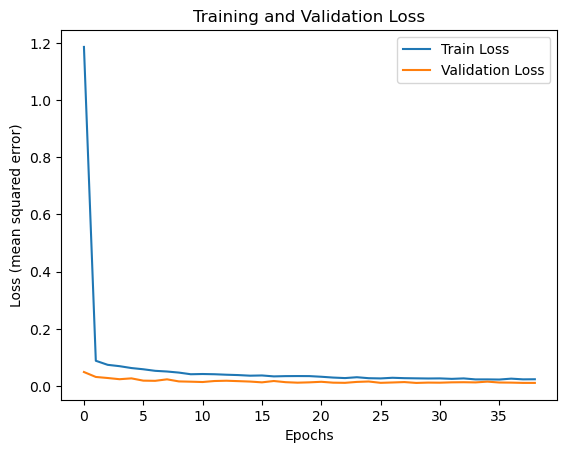

In [99]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (mean squared error)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


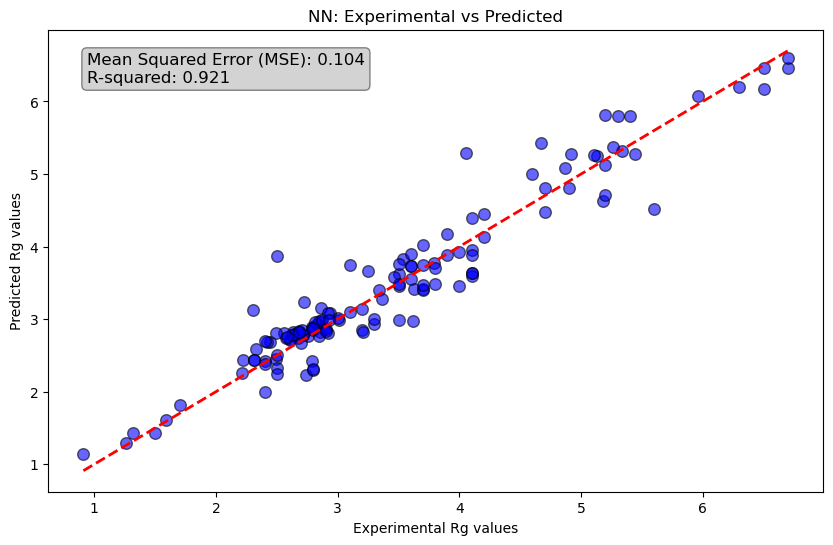

In [100]:
plt.figure(figsize=(10, 6))
plt.scatter(y_small, y_pred_nn, color='blue', edgecolor='k', alpha=0.6, s=70)
plt.plot([y_small.min(), y_small.max()], [y_small.min(), y_small.max()], 'r--', lw=2)
plt.xlabel('Experimental Rg values')
plt.ylabel('Predicted Rg values')
plt.title('NN: Experimental vs Predicted')

# Display MSE and R-squared inside the plot
text_str = f'Mean Squared Error (MSE): {mse_nn:.3f}\nR-squared: {r2_nn:.3f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'))

plt.show()

### (optional

#### to plot the loss vs the training set size we need to run in different way

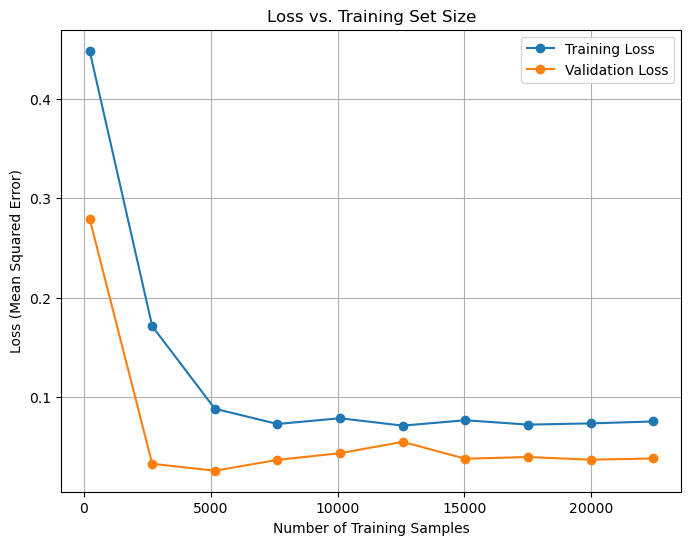

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Assume X_large and y_large are the 28,000 samples
# Preprocess data
scaler = StandardScaler()
X_large_scaled = scaler.fit_transform(X_large)

# Define sizes for subsets (e.g., 1%, 5%, 10%, ..., 100% of the dataset)
training_sizes = np.linspace(0.01, 1.0, 10)  # Fractions of training samples
training_losses = []
validation_losses = []

# Validation set (20% of the full dataset)
split_idx = int(0.8 * len(X_large_scaled))
X_train_full, X_val = X_large_scaled[:split_idx], X_large_scaled[split_idx:]
y_train_full, y_val = y_large[:split_idx], y_large[split_idx:]

for size in training_sizes:
    # Determine subset size
    subset_size = int(size * X_train_full.shape[0])
    X_train_subset = X_train_full[:subset_size]
    y_train_subset = y_train_full[:subset_size]

    # Define a small neural network model
    model = Sequential([
        Dense(64, input_shape=(X_train_full.shape[1],), activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model on the subset
    history = model.fit(X_train_subset, y_train_subset,
                        validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=0)

    # Record the final training and validation losses
    training_losses.append(history.history['loss'][-1])
    validation_losses.append(history.history['val_loss'][-1])

# Plot Loss vs. Training Set Size
plt.figure(figsize=(8, 6))
plt.plot(training_sizes * X_train_full.shape[0], training_losses, label='Training Loss', marker='o')
plt.plot(training_sizes * X_train_full.shape[0], validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Loss vs. Training Set Size')
plt.legend()
plt.grid()
plt.show()


/home/saeed/Softwares/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saeed/Softwares/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saeed/Softwares/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saeed/Softwares/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimiza

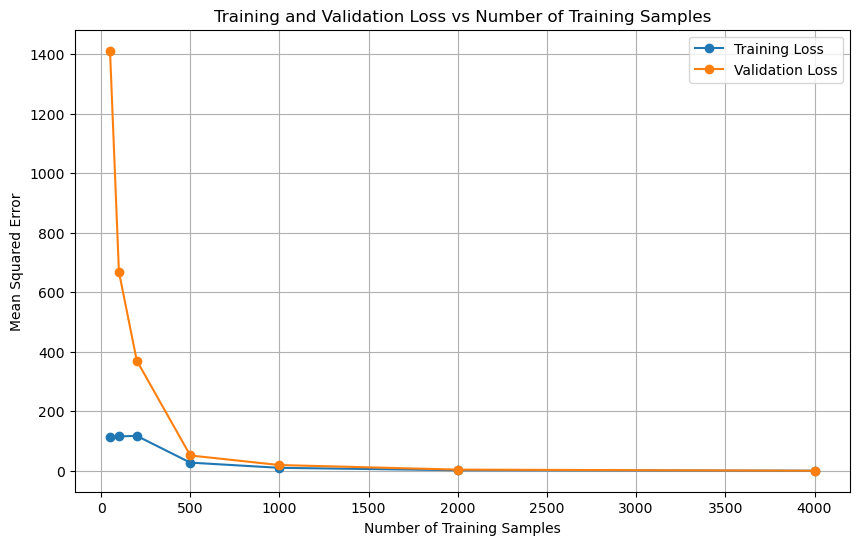

In [34]:
############### to check why our training loss is 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Generate a synthetic regression dataset
X, y = make_regression(n_samples=5000, n_features=10, noise=0.1, random_state=42)

# Initialize arrays to store results
train_samples = [50, 100, 200, 500, 1000, 2000, 4000]  # Number of training samples
training_loss = []
validation_loss = []

# Loop over different numbers of training samples
for n_samples in train_samples:
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Use only the first n_samples for training
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]
    
    # Train a simple neural network model
    model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    model.fit(X_train_subset, y_train_subset)
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_train_subset)
    y_val_pred = model.predict(X_test)
    
    # Calculate mean squared error
    train_loss = mean_squared_error(y_train_subset, y_train_pred)
    val_loss = mean_squared_error(y_test, y_val_pred)
    
    # Append results to arrays
    training_loss.append(train_loss)
    validation_loss.append(val_loss)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_samples, training_loss, label='Training Loss', marker='o')
plt.plot(train_samples, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss vs Number of Training Samples')
plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


### )

## to find the importance of features on Rg

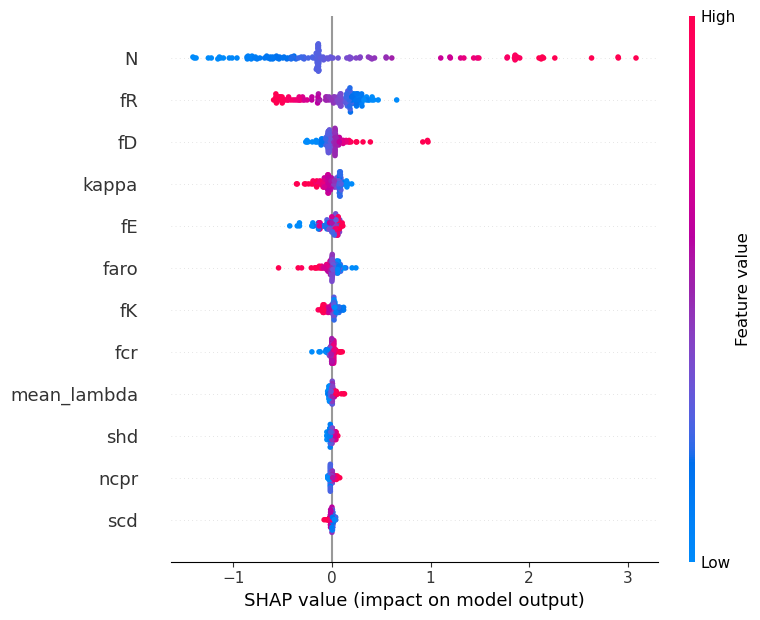

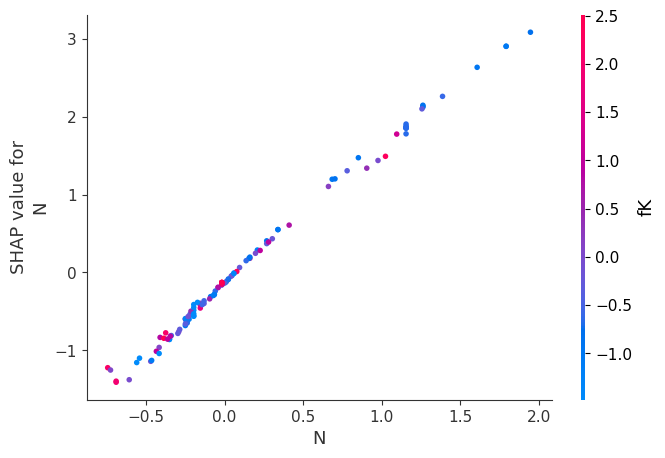

In [43]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Extract feature names 
feature_names = ['N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD','faro','kappa','fcr']  
X_test_df = pd.DataFrame(X_test, columns=feature_names)# Convert to DataFrame for better handling

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_test_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)


In [ ]:
# effect of each feature
# Create dependence plot for a single feature (e.g., 'f1')
for i, feature in enumerate(feature_names):
    print(f"Generating dependence plot for: {feature}")
    shap.dependence_plot(
        i,  # Feature index
        shap_values.values,
        X_test_df,
        feature_names=feature_names
    )

# thankGOD! delta Rg

### thankGOD! delta Rg for 137 exp of ALEX and predicted

In [110]:
#To load our trained model thankGOD!
Rg_model=joblib.load('NN_model.joblib')
y_pred_nn = Rg_model.predict(X_test)

5/5 [==============================] - 0s 582us/step


In [111]:
Rg_exp = np.array (y_small)
Rg_pred = np.array (y_pred_nn)

In [123]:
y_small.shape

(137,)

In [112]:
#delta_Cs = Cs_exp - Cs_pred
delta_Rg=[]

for i in range (len(y_pred_nn)):
    #print (delta_Rg[i])
    delta_Rg.append( Rg_exp[i]-Rg_pred[i] )
#print (delta_Rg.min())

In [119]:
delta_Rg = scaler.fit_transform(delta_Rg)
print (max(delta_Rg))
delta_Rg.shape

[3.4810061]


(137, 1)

In [114]:
#Clear the Session: If you’re running the script multiple times in the same session (e.g., in Jupyter), 
#clear TensorFlow's computational graph between runs to avoid accumulation:
from tensorflow.keras.backend import clear_session
clear_session()

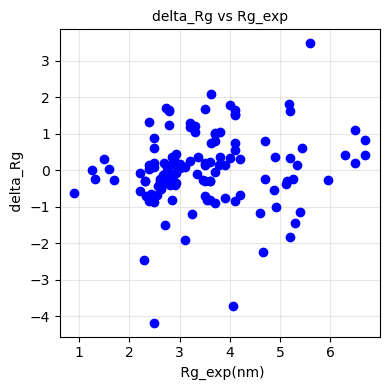

In [115]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(4,4))


ax.plot(Rg_exp, delta_Rg,'o',color='b')#,fillstyle='none')


ax.set(xlabel=f' Rg_exp(nm)', ylabel=f' delta_Rg')
ax.set_title('delta_Rg vs Rg_exp',fontsize=10)
ax.grid(alpha=0.3)

fig.tight_layout()

## ThankGOD! train the model on delta Rg

In [116]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


# Step 1: Split 137 sample that we have delta Rg into training/validation and test sets
X_train_val_dRg, X_test_dRg, y_train_val_dRg, y_test_dRg = train_test_split(X_test, delta_Rg, test_size=20/137, random_state=42)

# Split your X_train_val to X_train and X_val thankGOD!
X_train_dRg, X_val_dRg, y_train_dRg, y_val_dRg = train_test_split(X_train_val_dRg, y_train_val_dRg, test_size=0.2, random_state=42)


# Print sizes of each set
print(f"Training set: {X_train_dRg.shape}, Validation set: {X_val_dRg.shape}, Test set: {X_test_dRg.shape}")

# Standardize the data
scaler = StandardScaler()
X_train_dRg = scaler.fit_transform(X_train_dRg)
X_val_dRg = scaler.transform(X_val_dRg)

#y_train = scaler.fit_transform(y_train)
#y_val = scaler.fit_transform(y_val)

# Apply the same scaler to the smaller 64-sample dataset
X_test_dRg = scaler.transform(X_test_dRg)
delta_Rg = scaler.fit_transform(delta_Rg)
y_test_dRg=scaler.fit_transform(y_test_dRg)
#print (y_test_dRg)


Training set: (93, 12), Validation set: (24, 12), Test set: (20, 12)


In [129]:
# Standardize the data
scaler = StandardScaler()
#Rg_exp_2D=Rg_exp.reshape(+1)
y_test=scaler.fit_transform(Rg_exp)

### Step 3: Define the Neural Network Model with cross validation

### 5 fold cross val

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Define the Keras model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_test_dRg.shape[1]),
        Dropout(0.01),
        Dense(32, activation='relu'),
        Dropout(0.01),
        Dense(32, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(1, activation='linear')
    ])
    #model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define the early stopping callback
    early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []

all_y_true = []
all_y_pred = []

# Perform cross-validation
for train_index, val_index in kf.split(X_test_dRg):
    # Split the data
    X_train, X_val = X_test_dRg[train_index], X_test_dRg[val_index]
    y_train, y_val = y_test_dRg[train_index], y_test_dRg[val_index]

    # Create a new instance of the model
    model = create_model()
 
    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=72, callbacks=[early_stopping], verbose=1)

    # Predict on the test set
    y_pred_dRg = model.predict(X_test_dRg)

        # Append true and predicted values
    all_y_true.extend(y_test_dRg)
    all_y_pred.extend(y_pred_dRg.flatten())  # Flatten predictions
    
    mse = mean_squared_error(y_test_dRg, y_pred_dRg)
    mse_scores.append(mse)

      # Calculate R-squared
    r2 = r2_score(y_test_dRg, y_pred_dRg)
    r2_scores.append(r2)

# to save the trained model
joblib.dump(model, 'model_dRg.joblib')


# Calculate the mean and standard deviation of the MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Output results
print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Mean MSE: {mean_mse:.4f}, Std Dev: {std_mse:.4f}")
print(f"Cross-validated R-squared scores: {r2_scores}")
print(f"Mean R-squared: {mean_r2:.4f}, Std Dev: {std_r2:.4f}")


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(all_y_true, all_y_pred, alpha=0.7, edgecolor='k')
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], color='red', linestyle='--')  # Diagonal line
plt.title(f"Scatter Plot of True vs. Predicted Values\nMean $R^2$: {mean_r2:.4f}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(alpha=0.3)
plt.show()

### thankGOD! one leave out cross validation

In [130]:
#Clear the Session: If you’re running the script multiple times in the same session (e.g., in Jupyter), 
#clear TensorFlow's computational graph between runs to avoid accumulation:
from tensorflow.keras.backend import clear_session
clear_session()


In [131]:
import random
import tensorflow as tf

# Set random seed for reproducibility. Always will get same result. but if I do not use it, every time that I run I got slightly different results
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

### run one leave out for the whole 137 exp and not just for 20 of them (X_test instead of X_test_dRg

In [ ]:
#Modified Code for LOOCV

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import LeaveOneOut
import joblib

# Define the Keras model
def create_model():
    model = Sequential([
        Dense(64, activation='tanh', input_dim=X_test.shape[1]),
        Dropout(0.01),
        Dense(32, activation='tanh'),
        Dropout(0.01),
        Dense(32, activation='tanh'),
        Dropout(0.01),
        Dense(12, activation='tanh'),
        Dropout(0.01),
        Dense(12, activation='tanh'),
        Dropout(0.01),
        #Dense(12, activation='tanh'),
        #Dropout(0.01),
        Dense(1, activation='linear')
    ])
    #model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define the early stopping callback
    early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Cross-validation setup
#kf = KFold(n_splits=10, shuffle=True, random_state=42)
loo = LeaveOneOut()
mse_scores = []
r2_scores = []

all_y_true = []
all_y_pred = []

# Perform cross-validation
for train_index, val_index in loo.split(X_test):
    # Split the data
    X_train, X_val = X_test[train_index], X_test[val_index]
    y_train, y_val = y_test[train_index], y_test[val_index]

    # Create a new instance of the model
    model = create_model()
 
    # Train the model
    #without early stop
    #history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=1,  verbose=1)
    
    #with early stop
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=1, callbacks=[early_stopping], verbose=1)
   
    # Predict on the test set
    y_pred_dRg = model.predict(X_test)

    
        # Append true and predicted values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred_dRg.flatten())  # Flatten predictions
    
    mse = mean_squared_error(y_test, y_pred_dRg)
    mse_scores.append(mse)

      # Calculate R-squared
    r2 = r2_score(y_test, y_pred_dRg)
    r2_scores.append(r2)

# to save the trained model
joblib.dump(model, 'model_dRg.joblib')



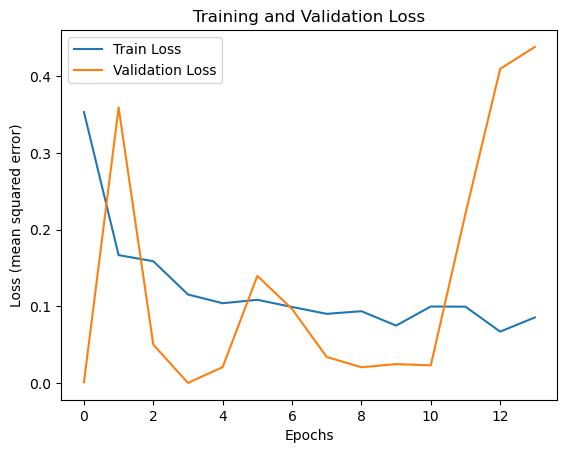

In [133]:

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (mean squared error)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Cross-validated MSE scores: [0.09375869106944142, 0.07857546963910961, 0.18243794563132446, 0.11891038759952259, 0.05976658034968677, 0.09749946627579482, 0.04338121334252418, 0.07266073316060993, 0.04944212713423818, 0.0370638255002767, 0.09823890928257481, 0.08537910179014646, 0.06291411827102224, 0.1122882351151094, 0.06495021767445748, 0.03526823766893581, 0.18633834246599434, 0.07137494664825766, 0.0933016605108056, 0.08090655470908575, 0.115852668177206, 0.07460653977892276, 0.07889907182077005, 0.10313740324043771, 0.06540572566181722, 0.08586956512304175, 0.08628024554246012, 0.045895665964897844, 0.14769471882205243, 0.18444612865846574, 0.10828398654177, 0.06290086173112501, 0.07056935403937785, 0.16359050071799144, 0.1384939383978563, 0.05394549350381311, 0.07769064984402603, 0.186093376285467, 0.14403576315493022, 0.1264264255241942, 0.12845070906548786, 0.15542996180348218, 0.06785933673227566, 0.1165234109314588, 0.1076652300555244, 0.06343159093660715, 0.1043565307952879

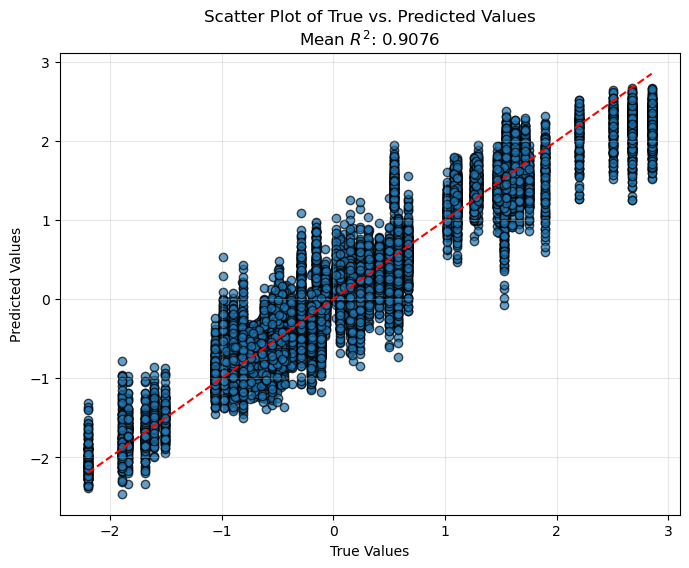

In [134]:
# Calculate the mean and standard deviation of the MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Output results
print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Mean MSE: {mean_mse:.4f}, Std Dev: {std_mse:.4f}")
print(f"Cross-validated R-squared scores: {r2_scores}")
print(f"Mean R-squared: {mean_r2:.4f}, Std Dev: {std_r2:.4f}")


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(all_y_true, all_y_pred, alpha=0.7, edgecolor='k')
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], color='red', linestyle='--')  # Diagonal line
plt.title(f"Scatter Plot of True vs. Predicted Values\nMean $R^2$: {mean_r2:.4f}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(alpha=0.3)
plt.show()

## determine the effect of features

###  SHAP (SHapley Additive exPlanations)

           N       shd       scd  mean_lambda      ncpr        fK        fR  \
0  -0.427757 -0.924201 -0.010926     0.132590  1.806385 -0.577247 -0.435765   
1   2.198263  0.064184 -0.830938     0.497948  0.860441 -0.405733 -0.792773   
2  -0.193091 -0.807920  0.220817    -0.963485 -0.647158 -0.386676  1.245627   
3  -0.159568  0.975047 -1.080508     1.393075 -0.233308 -0.405733 -1.380108   
4   3.203973  0.839387 -0.510064     0.150858  0.446590 -0.882161 -0.884904   
5   2.008296 -0.807920 -0.010926    -0.415447  0.003179 -0.710647 -0.216954   
6  -0.707121 -0.885441 -0.884418     0.845038  1.096927 -0.177047 -1.103715   
7  -0.941787  0.006043 -1.080508     0.077786  1.865507 -0.138933 -0.562445   
8  -0.628899 -0.711020 -1.080508    -0.214501  1.510778 -0.443847 -0.286052   
9   2.209437  0.936287 -0.367453     0.022982  0.417029 -0.786875 -0.792773   
10  2.209437  0.936287 -0.367453     0.223929  0.417029 -0.786875 -0.850355   
11 -0.148393  0.006043  0.434733    -0.177965 -1.504

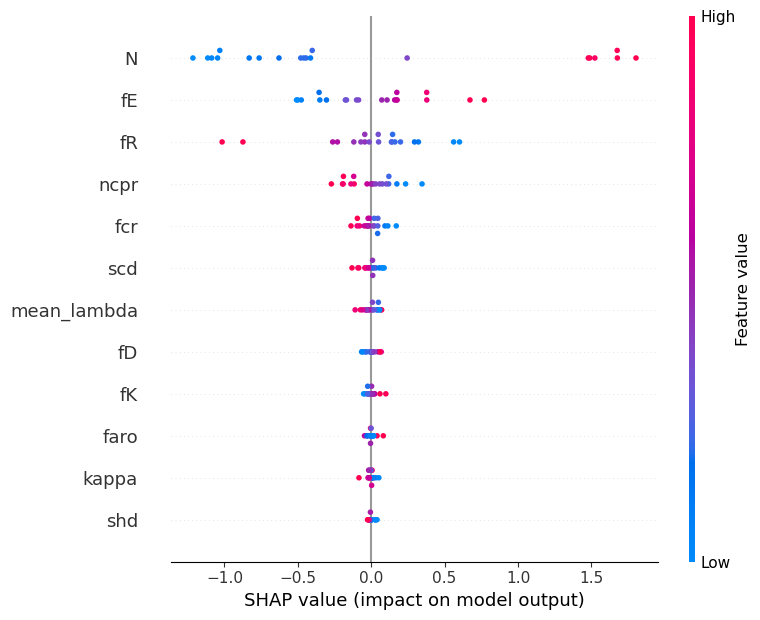

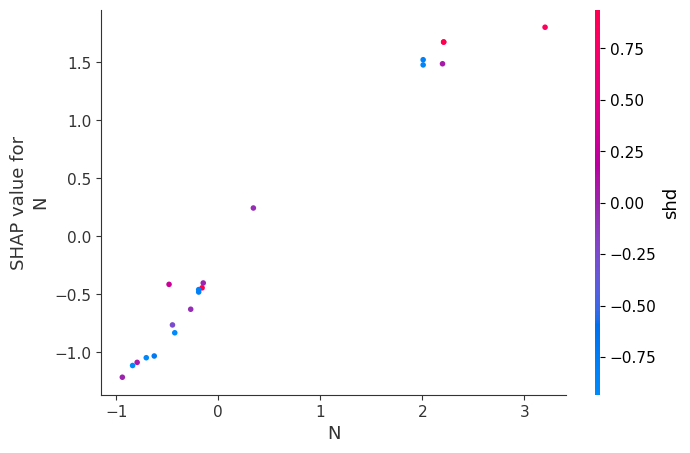

In [138]:
# find relationship of features and the whole 137 samples
import shap
import matplotlib.pyplot as plt

# Load the saved model
model_dRg = joblib.load('model_dRg.joblib')

# Create a SHAP explainer
explainer = shap.Explainer(model_dRg, X_test_dRg)
shap_values = explainer(X_test_dRg)

# Extract feature names 
feature_names = ['N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD','faro','kappa','fcr']  
X_test_dRg_df = pd.DataFrame(X_test_dRg, columns=feature_names)# Convert to DataFrame for better handling
print(X_test_dRg_df)
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_dRg, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_test_dRg_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

1295/1295 [==============================] - 0s 271us/step
           N       shd       scd  mean_lambda      ncpr        fK        fR  \
0  -0.427757 -0.924201 -0.010926     0.132590  1.806385 -0.577247 -0.435765   
1   2.198263  0.064184 -0.830938     0.497948  0.860441 -0.405733 -0.792773   
2  -0.193091 -0.807920  0.220817    -0.963485 -0.647158 -0.386676  1.245627   
3  -0.159568  0.975047 -1.080508     1.393075 -0.233308 -0.405733 -1.380108   
4   3.203973  0.839387 -0.510064     0.150858  0.446590 -0.882161 -0.884904   
5   2.008296 -0.807920 -0.010926    -0.415447  0.003179 -0.710647 -0.216954   
6  -0.707121 -0.885441 -0.884418     0.845038  1.096927 -0.177047 -1.103715   
7  -0.941787  0.006043 -1.080508     0.077786  1.865507 -0.138933 -0.562445   
8  -0.628899 -0.711020 -1.080508    -0.214501  1.510778 -0.443847 -0.286052   
9   2.209437  0.936287 -0.367453     0.022982  0.417029 -0.786875 -0.792773   
10  2.209437  0.936287 -0.367453     0.223929  0.417029 -0.786875 -0.850

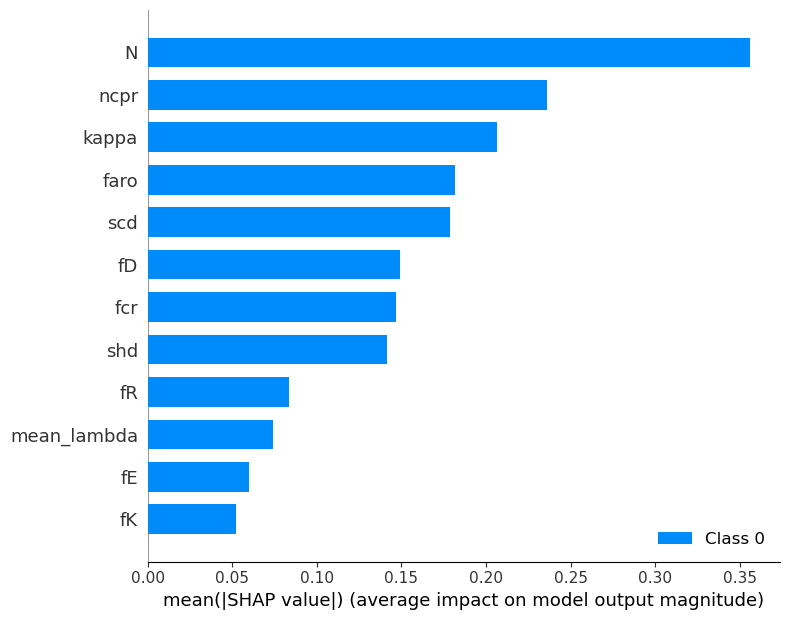

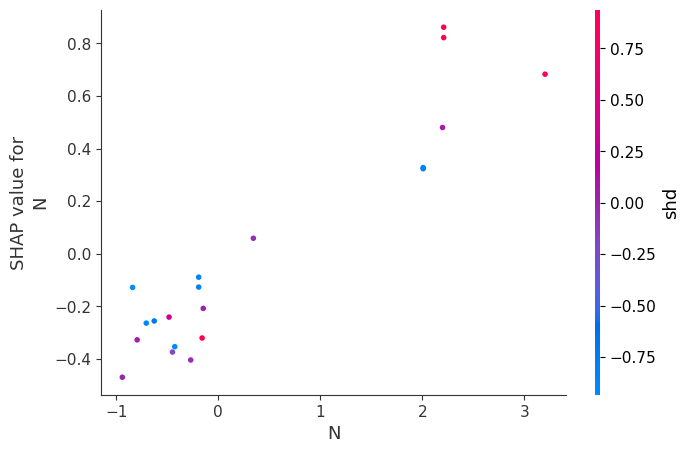

In [64]:
# to have fixed random_state so always get same Shap results and plots thankGOD!
import shap
import matplotlib.pyplot as plt



# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict, X_test_dRg, random_state=42)
shap_values = explainer.shap_values(X_test_dRg)

# Extract feature names 
feature_names = ['N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD','faro','kappa','fcr']  
X_test_dRg_df = pd.DataFrame(X_test_dRg, columns=feature_names)# Convert to DataFrame for better handling
print(X_test_dRg_df)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_dRg, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values[0],  # SHAP values for the test dataset
    features=X_test_dRg_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)


In [ ]:
# effect of each feature
# Create dependence plot for a single feature (e.g., 'f1')
for i, feature in enumerate(feature_names):
    print(f"Generating dependence plot for: {feature}")
    shap.dependence_plot(
        i,  # Feature index
        shap_values.values,
        X_test_dRg_df,
        feature_names=feature_names
    )


           N       shd       scd  mean_lambda      ncpr        fK        fR  \
0  -0.450106 -1.098622 -0.759633     1.594022  1.096927  0.108810 -0.896420   
1   0.611476 -0.168378 -0.492238     0.004714 -0.381111  0.318439  0.243701   
2   1.762455 -0.904821 -0.902244    -0.780806 -1.327056  1.404696  0.324316   
3  -0.628899  1.672731 -0.902244    -0.214501  0.003179 -0.844047 -0.700642   
4   2.008296 -0.866061 -0.064405    -0.305840 -0.085504 -0.653476 -0.205437   
..       ...       ...       ...          ...       ...       ...       ...   
88  0.142145  1.110708 -0.759633    -0.196233  0.269225 -0.767818 -0.758224   
89  0.477382  1.556450 -0.438759     0.150858 -0.292429 -0.844047 -0.781256   
90 -0.528328  0.161084  0.256470     0.059518  0.712637 -1.225190 -0.884904   
91 -0.573026 -0.730400 -0.902244     4.352475  1.362974 -0.481961 -1.794698   
92 -0.193091 -0.807920  0.220817    -0.963485  1.096927  1.557153  1.303208   

          fE        fD      faro     kappa       fc

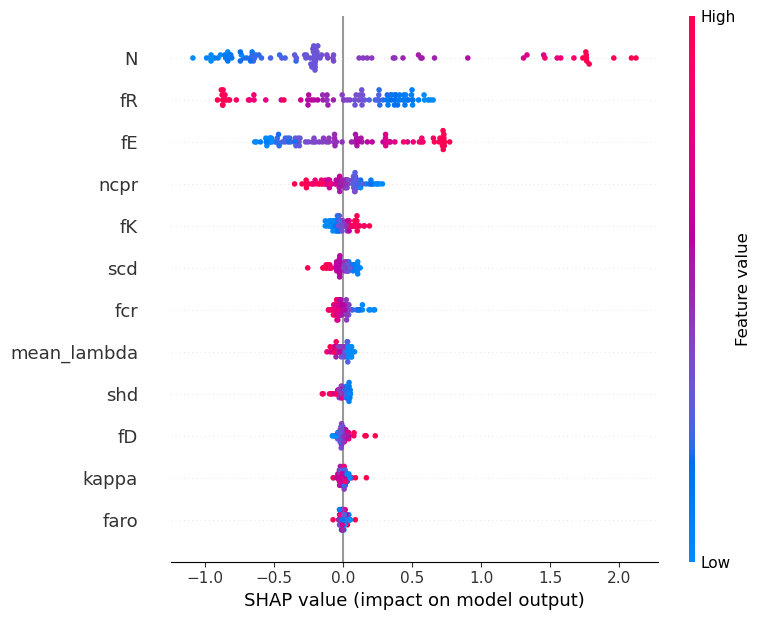

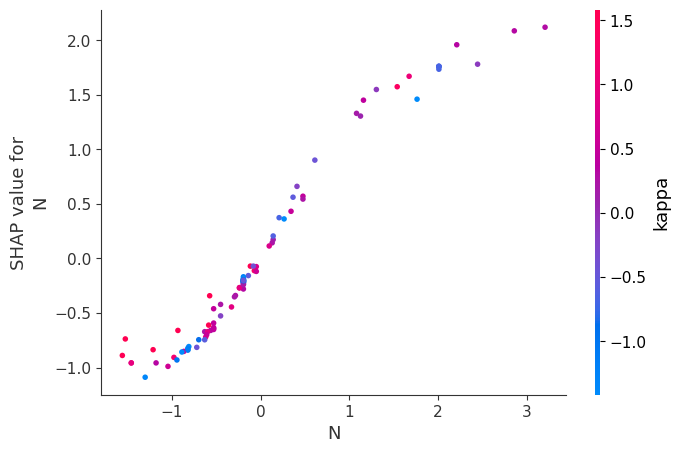

In [136]:
# find relationship of features and the train set (93 samples) of 137 samples
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model_dRg, X_train_dRg)
shap_values = explainer(X_train_dRg)

# Extract feature names 
feature_names = ['N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD','faro','kappa','fcr']  
X_train_dRg_df = pd.DataFrame(X_train_dRg, columns=feature_names)# Convert to DataFrame for better handling
print(X_train_dRg_df)
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_train_dRg, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_train_dRg_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)


In [ ]:
# effect of each feature
# Create dependence plot for a single feature (e.g., 'f1')
for i, feature in enumerate(feature_names):
    print(f"Generating dependence plot for: {feature}")
    shap.dependence_plot(
        i,  # Feature index
        shap_values.values,
        X_train_dRg_df,
        feature_names=feature_names
    )

### this the correct one which is on the whole 137 samples thankGOD!

            N       shd       scd  mean_lambda      ncpr        fK        fR  \
0   -0.017143 -0.885339 -1.480334    -1.450214 -0.536922  2.511159  3.428626   
1   -0.017143  0.720876 -1.480334    -1.450214 -0.536922  2.319798  2.770454   
2   -0.017143 -0.885339  0.306415    -1.450214 -0.536922  2.319798  3.738354   
3   -0.017143 -0.885339 -1.480334    -1.450214 -0.536922  2.511159  3.622206   
4   -0.017143 -0.423277 -0.232057    -1.450214 -0.536922  2.319798  3.312478   
..        ...       ...       ...          ...       ...       ...       ...   
132 -0.154092 -0.247253 -0.623674     0.374140  2.190689 -0.031211 -0.791416   
133 -0.249360 -0.775324 -1.480334    -0.671063  1.581329 -0.359259  0.157125   
134  0.780733 -0.313262  0.135083    -0.462022  0.130472 -0.359259 -0.055813   
135  1.947776  0.478843 -0.060725     0.013070 -0.333802 -0.769319 -0.501046   
136 -0.541121 -1.215383  3.023251    -0.671063 -0.798076 -1.480089  2.054209   

           fE        fD      faro     k

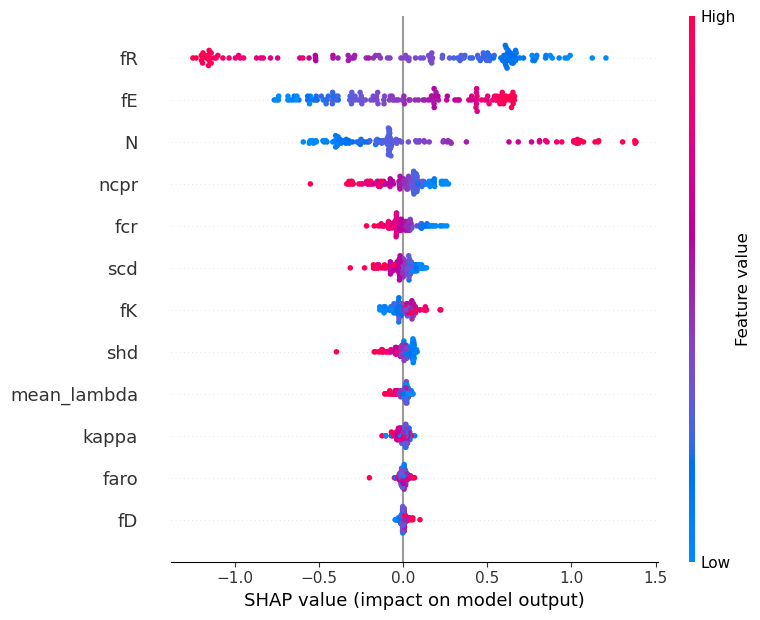

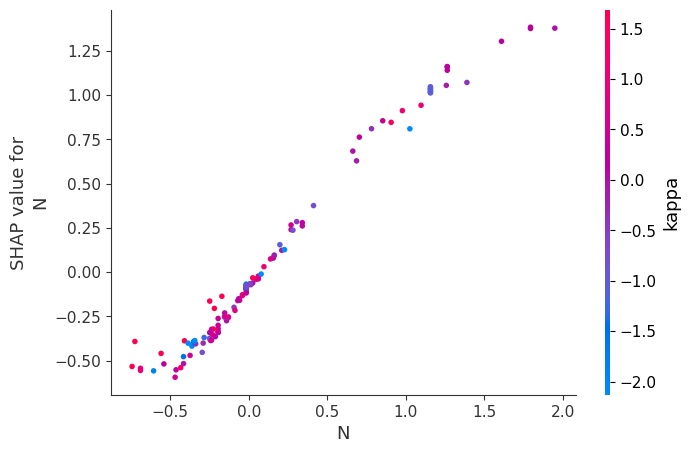

In [137]:
# find relationship of features and the whole 137 samples (delta_Rg)
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model_dRg, X_test)
shap_values = explainer(X_test)

# Extract feature names 
feature_names = ['N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD','faro','kappa','fcr']  
X_train_dRg_df = pd.DataFrame(X_test, columns=feature_names)# Convert to DataFrame for better handling
print(X_train_dRg_df)
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_train_dRg_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)

5/5 [==============================] - 0s 677us/step


Using 137 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/137 [00:00<?, ?it/s]

8871/8871 [==============================] - 2s 222us/step


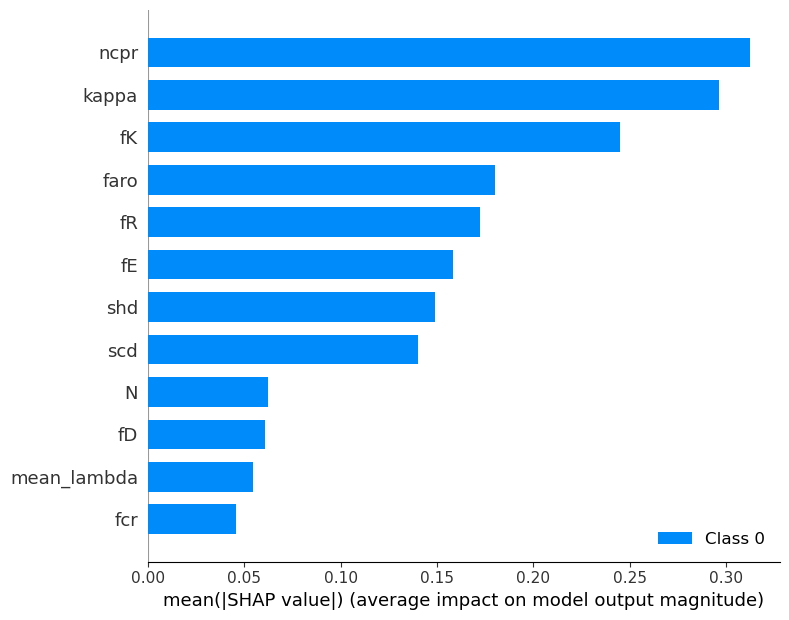

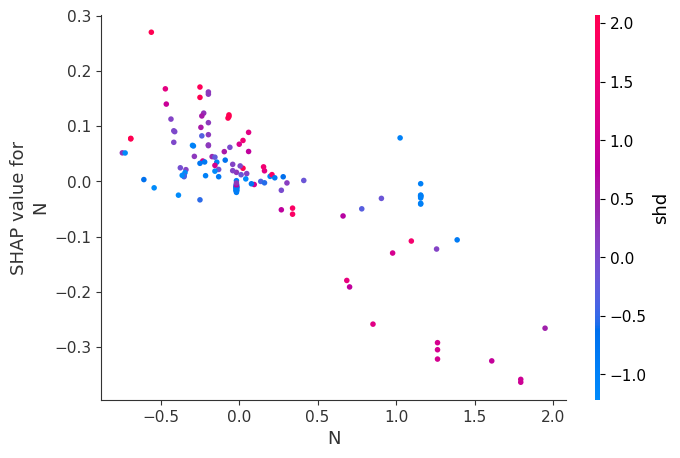

In [30]:
# to have fixed random_state so always get same Shap results and plots thankGOD!
import shap
import matplotlib.pyplot as plt



# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict, X_test, random_state=42)
shap_values = explainer.shap_values(X_test)

# Extract feature names 
feature_names = ['N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD','faro','kappa','fcr']  
X_test_dRg_df = pd.DataFrame(X_test, columns=feature_names)# Convert to DataFrame for better handling
#print(X_test_dRg_df)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values[0],  # SHAP values for the test dataset
    features=X_test_dRg_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)